<a href="https://colab.research.google.com/github/Andre6o6/stylegan-editing/blob/master/Train_initial_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial approximation prediction

## Training

In [ ]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm as tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from interfacegan.models.stylegan_generator import StyleGANGenerator
from models.initial_prediction import InitialLatentPredictor
from models.loss import LogCoshLoss

In [ ]:
class ImageLatentDataset(Dataset):
    def __init__(self, filenames, dlatents, transforms=None):
        self.filenames = filenames
        self.dlatents = dlatents
        self.transforms = transforms

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        dlatent = self.dlatents[index]

        image = Image.open(filename)
        if self.transforms:
            image = self.transforms(image)

        return image, dlatent

In [ ]:
# Define augmentations needed for ResNet inputs
image_size = 256
augments = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Get previously generated data and split into train and validation
# NOTE data was generated with this script: interfacegan/generate_data.py -m stylegan_ffhq -n 50000 ...
filenames = sorted(glob("data/images/*.jpg"))
train_filenames = filenames[0:48000]
val_filenames = filenames[48000:]

dlatents = np.load("data/dlatents/wp.npy")
train_dlatents = dlatents[0:48000]
val_dlatents = dlatents[48000:]

# Initialize Datasets and Dataloader
train_set = ImageLatentDataset(train_filenames, train_dlatents, transforms=augments)
val_set = ImageLatentDataset(val_filenames, val_dlatents, transforms=augments)

train_generator = DataLoader(train_set, batch_size=32)
val_generator = DataLoader(val_set, batch_size=32)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = InitialLatentPredictor().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = LogCoshLoss()

In [ ]:
epochs = 20
validation_loss = 0.0
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:    
        running_loss = 0.0
        model.train()
        for i, (images, latents) in enumerate(train_generator, 1):
            optimizer.zero_grad()

            images, latents = images.to(device), latents.to(device)
            pred_latents = model(images)
            loss = criterion(pred_latents, latents)
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_description(
                "Step: {}, Loss: {:.5f}, Val Loss: {:.5f}".format(
                    i, 
                    running_loss/i, 
                    validation_loss
                )
            )
        
        validation_loss = 0.0
        model.eval()
        for i, (images, latents) in enumerate(val_generator, 1):
            with torch.no_grad():
                images, latents = images.to(device), latents.to(device)
                pred_latents = model(images)
                loss =  criterion(pred_latents, latents)
                
                validation_loss += loss.item()
        validation_loss /= i

        torch.save(model.state_dict(), "image_to_latent_{}.pt".format(epoch))

Step: 1500, Loss: 0.0056, Val Loss: 0.0080: 100%|██████████| 20/20 [2:29:17<00:00, 447.86s/it]


In [ ]:
torch.save(model.state_dict(), "image_to_latent.pt")

## Testing

In [ ]:
from models.latent_optimization import denormalize

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_to_latent = InitialLatentPredictor().to(device)
image_to_latent.load_state_dict(torch.load("image_to_latent.pt"))
image_to_latent.eval()
print()

In [ ]:
def tensor_to_numpy_image(image):
    mean=torch.tensor([0.485, 0.456, 0.406]).view(-1,1,1).float()
    std=torch.tensor([0.229, 0.224, 0.225]).view(-1,1,1).float()
    
    image = image.detach().cpu()
    image = 255*(image*std + mean)
    
    image = image.numpy()[0]
    image = np.transpose(image, (1,2,0))
    return image.astype(np.uint8)

# Get n images from validation dataset
num_test_images = 5
images = [val_set[i][0].unsqueeze(0).to(device) for i in range(num_test_images)]
normal_images = [tensor_to_numpy_image(x) for x in images]

# Predict latent vectors for images
pred_dlatents = map(image_to_latent, images)

# Load StyleGAN model and define postprocessing
synthesizer = StyleGANGenerator("stylegan_ffhq").model.synthesis
post_process = lambda image: denormalize(image).detach().cpu().numpy().astype(np.uint8)[0]

# Generate images from predicted vectors and convert to Numpy 
pred_images = map(synthesizer, pred_dlatents)
pred_images = map(post_process, pred_images)
pred_images = list(map(lambda image: np.transpose(image, (1,2,0)), pred_images))

[2020-06-15 18:24:15,820][INFO] Loading pytorch model from `interfacegan/models/pretrain/stylegan_ffhq.pth`.
[2020-06-15 18:24:19,229][INFO] Successfully loaded!
[2020-06-15 18:24:19,230][INFO]   `lod` of the loaded model is 0.0.


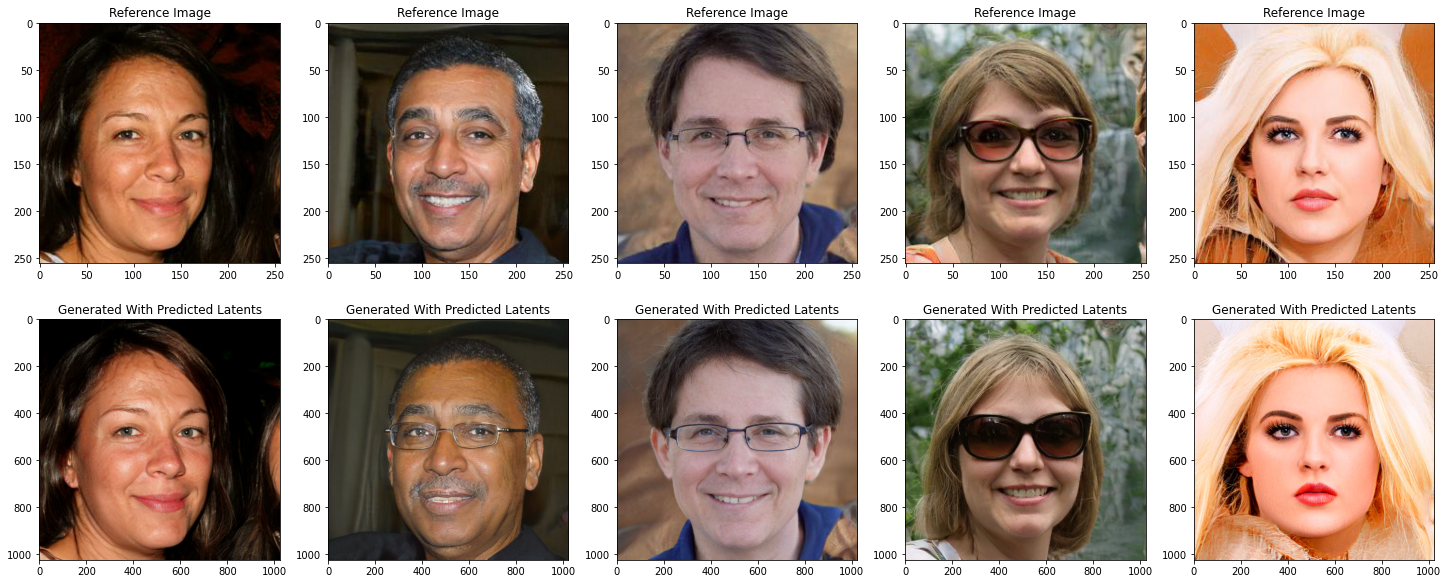

In [ ]:
# Plot images from validation dataset and images, generated from predicted latent vectors
figure = plt.figure(figsize=(25,10))
columns = len(normal_images)
rows = 2

axis = []
for i in range(columns):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Reference Image")
    plt.imshow(normal_images[i])

for i in range(columns, columns*rows):
    axis.append(figure.add_subplot(rows, columns, i + 1))
    axis[-1].set_title("Generated With Predicted Latents")
    plt.imshow(pred_images[i - columns])

plt.show()